In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import time
import json
import shutil
import pathlib
from pprint import pprint
from tqdm import tqdm

In [76]:
%%script bash --bg
../elasticsearch-6.2.2/bin/elasticsearch

In [77]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import time
import json
import shutil
import pathlib
from pprint import pprint
from tqdm import tqdm

In [78]:
!sleep 30 # Wait for ES

In [79]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

def get_es_size():
    res = !du -sh ../elasticsearch-6.2.2/
    return res.s.split()[0]

es = Elasticsearch()
es.indices.delete(index='ettoday', ignore_unavailable=True)
size_before = get_es_size()

json_paths = sorted(pathlib.Path('../data/json').glob('*.json'))
batch_size = 1000

actions = []
for path in tqdm(json_paths):
    with path.open() as f:
        record = json.load(f)
    actions.append({
        '_index': 'ettoday',
        '_type': 'news',
        '_id': int(path.stem),
        '_source': record,
    })
    if len(actions) == batch_size:
        helpers.bulk(es, actions)
        actions = []    
if len(actions) > 0:
    helpers.bulk(es, actions)

size_after = get_es_size()
print('ES size before:', size_before)
print('ES size after :', size_after)

100%|██████████| 20000/20000 [00:25<00:00, 786.39it/s]


ES size before: 32M
ES size after : 146M


In [80]:
queries = np.load('../data/queries.npy')

query = {
    "query": {
        "query_string": {
            "query": '*',
        }
    },
    "sort": [
        { '_score': 'desc' },
        { '_id': 'asc' }
    ],
}

def es_query(q):
    query['query']['query_string']['query'] = q
    res = es.search(index='ettoday', doc_type='news', body=query)
    return int(res['took'])


# Note that CPU is not utilized to 100%
df = pd.DataFrame(columns=['size', 'es_time', 'es_real_time'])
es_time = 0
start_time = time.time()

for i, q in enumerate(tqdm(queries)):
    es_time += es_query(q)
    if (i + 1) % 1000 == 0:
        data = {
            'size': i + 1, 
            'es_time': es_time / 1000, 
            'es_real_time': time.time() - start_time
        }
        df = df.append(data, ignore_index=True)

df.to_csv('../data/es_df.csv', index=False)

100%|██████████| 10000/10000 [01:29<00:00, 111.91it/s]


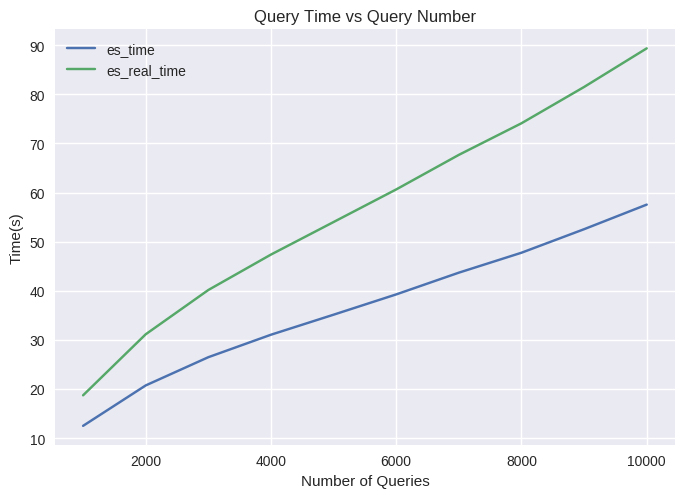

In [81]:
fig, ax = plt.subplots(dpi=100)
df.plot(ax=ax, x='size', y='es_time')
df.plot(ax=ax, x='size', y='es_real_time')
ax.set_ylabel('Time(s)')
ax.set_xlabel('Number of Queries')
ax.set_title('Query Time vs Query Number')
plt.show()

In [82]:
!pkill -f elasticsearch